<a href="https://colab.research.google.com/github/aditya-shriwastava/colab-notebooks/blob/master/visual_odometry.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# pip3 install

In [1]:
!pip3 install scikit-image

# import

In [2]:
import os

import numpy as np

import cv2
from google.colab.patches import cv2_imshow

import matplotlib.pyplot as plt
%matplotlib inline

from skimage.measure import ransac

# Load kitti dataset

In [3]:
if "2011_09_26_drive_0020_sync.zip" not in os.listdir():
  !wget https://s3.eu-central-1.amazonaws.com/avg-kitti/raw_data/2011_09_26_drive_0020/2011_09_26_drive_0020_sync.zip
  !unzip  2011_09_26_drive_0020_sync.zip >/dev/null

dataset_dir = "./2011_09_26/2011_09_26_drive_0020_sync/image_02"
imgs_dir = os.path.join(dataset_dir, "data")
timestamps_file_path = os.path.join(dataset_dir, "timestamps.txt")

imgs_file_name = os.listdir(imgs_dir)
imgs_file_name.sort()

imgs_file_path = [os.path.join(imgs_dir, img_file_name) for img_file_name in imgs_file_name]
kitti_imgs = np.array([cv2.imread(img_file_path) for img_file_path in imgs_file_path])

--2021-12-30 04:13:17--  https://s3.eu-central-1.amazonaws.com/avg-kitti/raw_data/2011_09_26_drive_0020/2011_09_26_drive_0020_sync.zip
Resolving s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)... 52.219.47.187
Connecting to s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)|52.219.47.187|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 367093728 (350M) [application/zip]
Saving to: ‘2011_09_26_drive_0020_sync.zip’

2011_09_26_drive_00 100%[===================>] 350.09M  20.6MB/s    in 21s     

2021-12-30 04:13:38 (17.0 MB/s) - ‘2011_09_26_drive_0020_sync.zip’ saved [367093728/367093728]



In [4]:
kitti_cam_calib = np.array([[7.215377e+02,0.000000e+00,6.095593e+02],
                            [0.000000e+00,7.215377e+02,1.728540e+02],
                            [0.000000e+00,0.000000e+00,1.000000e+00]])

# Disp utils

In [5]:
def disp(img_tn1, kps_tn1, kps_t):
  disp_img = img_tn1.copy()
  for kp_tn1, kp_t in zip(kps_tn1, kps_t):
    start_point = tuple(kp_tn1)
    end_point = tuple(kp_t)
    disp_img = cv2.circle(disp_img, start_point, 2, (0, 0, 255), 2)
    disp_img = cv2.line(disp_img, start_point, end_point, (0, 0, 255), 1)
  cv2_imshow(disp_img)

# EssentialMatrixTransform

In [6]:
class EssentialMatrixTransform():
  def __init__(self):
    self.params = np.eye(3)

  def estimate(self, kps_tn1, kps_t):
    # Setup constraint matrix
    A = np.column_stack((
      kps_tn1[:,0] * kps_t[:,0],
      kps_tn1[:,0] * kps_t[:,1],
      kps_tn1[:,0],
      kps_tn1[:,1] * kps_t[:,0],
      kps_tn1[:,1] * kps_t[:,1],
      kps_tn1[:,1],
      kps_t[:,0],
      kps_t[:,1],
      np.ones(len(kps_tn1)),
    ))

    # Solve for nullsapce of the constraint matrix
    u, s, vt = np.linalg.svd(A)
    E = vt[-1,:].reshape(3,3)

    # Enforcing first and second singular values are equal
    # and third singular value is zero
    u, s, vt = np.linalg.svd(E)
    s[0] = s[1] = (s[0] + s[1])/2
    s[2] = 0
    self.params = u @ np.diag(s) @ vt

    return True

  def residuals(self, kps_tn1, kps_t):
    # point-to-epipolar line distance
    # suffix underscore indicate homogeneous coordimate
    kps_tn1_ = np.column_stack([kps_tn1, np.ones(kps_tn1.shape[0])])
    kps_t_ = np.column_stack([kps_t, np.ones(kps_t.shape[0])])

    e_tn1 = kps_t_ @ self.params.T  # Epipilar line on tn1 image
    e_t = kps_tn1_ @ self.params  # Epipilar line on t image
    
    residue = (kps_tn1_ * e_tn1).sum(axis = 1) # Residue from coplanarity constraint

    return np.abs(residue) / np.sqrt(e_tn1[:,0]**2 + e_tn1[:,1]**2
                                     + e_t[:,0]**2 + e_t[:,1]**2)

## Test

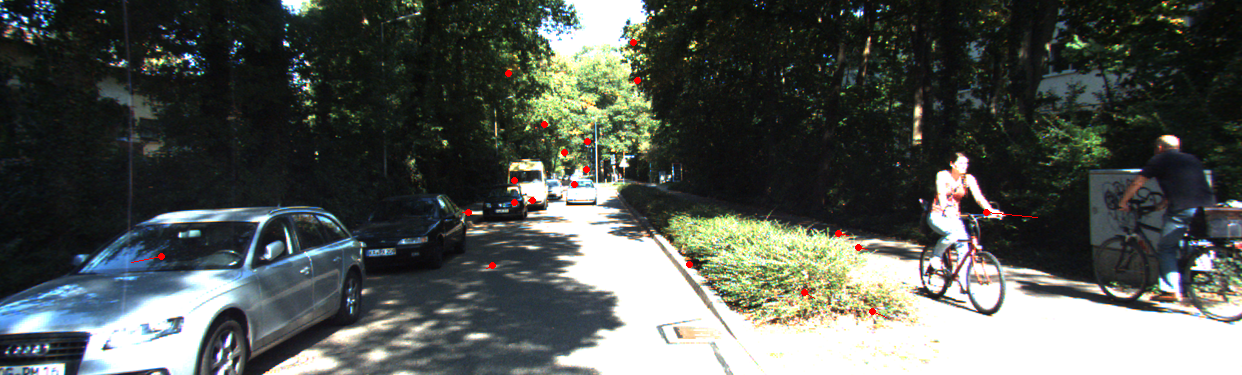

Fundamental Matrix: [[-1.17664368e-06 -2.81891581e-04  4.70289552e-02]
 [ 2.77459065e-04 -8.07524563e-07 -1.77481406e-01]
 [-4.48496765e-02  1.80770080e-01 -9.65193844e-01]]
Residuals for corresponding points:
[0.37130621 1.20965691 0.18079432 0.86765648 0.45992559 0.22238851
 0.40008999 0.22983077 0.3850392  0.22364134 0.55982321 0.60125545
 0.67377815 0.03606049 0.12180513 0.00393741 0.54630653 0.11318071
 0.29818723 0.00961099]
Residuals for random points:
[65.00264103  1.20965691 47.85055052 29.4282304  47.38003732 41.77980095
 81.48653042 99.44359787 32.49416074  1.29993416 84.11753859 47.56655968
 58.84434407 56.6822398  38.69966719 26.3864604  14.25209583 90.68196989
 18.35744817 12.0522954 ]


In [7]:
img_tn1 = kitti_imgs[0]
img_t = kitti_imgs[1]

# Ground truth corresponding Keypoints in img_tn1 and img_t
kps_tn1 = np.array([[838,233],[508,73],[514,180],[468,212],[587,141],[492,265],[986,212],[633, 42],[872,311],[544,124],
                    [804,292],[858,247],[689,264],[161,256],[574,184],[637,80],[532,200],[514,202],[564,152],[586,169]])

kps_t = np.array([[ 848,235],[506,72],[512,180],[462,212],[587,141],[486,268],[1037,217],[632,39],[886,317],[542,124],
                  [814,298],[867,249],[690,267],[131,262],[572,184],[636,79],[528,200],[512,202],[564,152],[585,169]])

disp(img_tn1, kps_tn1, kps_t)

F = FundamentalMatrixTransform()
F.estimate(kps_tn1, kps_t)

print(f"Fundamental Matrix: {F.params}")

print("Residuals for corresponding points:")
print(F.residuals(kps_tn1, kps_t))

print("Residuals for random points:")
permutation = np.random.choice(range(20), replace=False, size=20)
print(F.residuals(kps_tn1, kps_t[permutation]))

# Features utils

In [8]:
def extract_features(img):
  """
  Args
    img: numpy array of shape (H,W,C) representing image
  Returns
    kps: numpy array of shape (N, 2) representing coordinates of N
      keypoints detected
    des: numpy array of shape (N, 32) representing 32 dim descriptor
      of N keypoints
  """
  img = np.expand_dims(np.mean(img, axis=2).astype(np.uint8), -1)
  orb = cv2.ORB_create(nfeatures=5000)
  kps, des = orb.detectAndCompute(img, None)
  kps = np.array([[kp.pt[0], kp.pt[1]] for kp in kps]).astype(np.int32)
  return kps, des


def match_features(des_tn1, des_t):
  bf_matcher = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
  matches = bf_matcher.match(des_tn1, des_t)
  return np.array([[match.queryIdx, match.trainIdx] for match in matches])

def match_features2(des_tn1, des_t):
  bf_matcher = cv2.BFMatcher(cv2.NORM_HAMMING)
  matches = bf_matcher.knnMatch(des_tn1, des_t, k=2)

  idx_tn1, idx_t = [], []
  for m1, m2 in matches:
    # Lowe's ratio test
    if m1.distance <= 1 * m2.distance:
      if m1.distance < 32:
        if m1.trainIdx not in idx_t:
          idx_tn1.append(m1.queryIdx)
          idx_t.append(m1.trainIdx)

  assert len(idx_tn1) >= 8, f"#matches: {len(idx_tn1)}" 
  return np.array([idx_tn1, idx_t]).T

# Main

In [12]:
"""
TODO
- Select the correct solution by triangulation of a point and choosing
  the solution where the point is in front of both cameras.
  1. Essential Matrix --> R,t
  2. Fundamental Matrix --> R,t
"""

def trangulate():
  pass

def EssentiaToR(E):
  u,s,vt = np.linalg.svd(E)
  pwp = np.array([[0,1,0],
                  [-1,0,0],
                  [0,0,1]])
  nwp = -pwp
  pwn = np.array([[0,-1,0],
                  [1,0,0],
                  [0,0,1]])
  nwn = -pwn
  R_pwp = u @ pwp.T @ vt
  if (np.diag(R_pwp) > 0).all():
    print("pwp")
    return R_pwp
  R_nwp = u @ nwp.T @ vt
  if (np.diag(R_nwp) > 0).all():
    print("nwp")
    return R_nwp
  R_pwn = u @ pwn.T @ vt
  if (np.diag(R_pwn) > 0).all():
    print("pwn")
    return R_pwn
  R_nwn = u @ nwn.T @ vt
  if (np.diag(R_nwn) > 0).all():
    print("nwn")
    return R_nwn

def skew_to_vec(skew):
  skew = (skew - skew.T)/2
  vec = np.array([skew[2,1], skew[0,2], skew[1,0]])
  return vec

def EssentiaTot(E):
  u,s,vt = np.linalg.svd(E)
  pwp = np.array([[0,1,0],
                  [-1,0,0],
                  [0,0,1]])
  nwp = -pwp
  pwn = np.array([[0,-1,0],
                  [1,0,0],
                  [0,0,1]])
  nwn = -pwn
  t1 = u @ pwp @ np.diag(s) @ u.T
  t2 = u @ nwp @ np.diag(s) @ u.T
  t3 = u @ pwn @ np.diag(s) @ u.T
  t4 = u @ nwn @ np.diag(s) @ u.T
  return skew_to_vec(t1), skew_to_vec(t2), skew_to_vec(t3), skew_to_vec(t4)

In [41]:

def triangulate(x_tn1, x_t, R, t):
  pass

def EssentiaToRt(E):
  u,s,vt = np.linalg.svd(E)
  w = np.array([[0,-1,0],
                [1,0,0],
                [0,0,1]])
  R1 = u @ w.T @ vt
  if np.linalg.det(R1) < 0:
    R1 = -R1
  R2 = u @ w @ vt
  if np.linalg.det(R2) < 0:
    R2 = -R2

  print(f"R1: {R1}, |R1| = {np.linalg.det(R1)}")
  print(f"R2: {R2}, |R2| = {np.linalg.det(R2)}")

  t1 = u @ w @ np.diag(s) @ u.T
  t2 = -t1

  print(f"t1: {t1}")
  print(f"t2: {t2}")

#kps_tn1: 4947 #kps_t: 4933
Before RANSAC
#matches: 1858


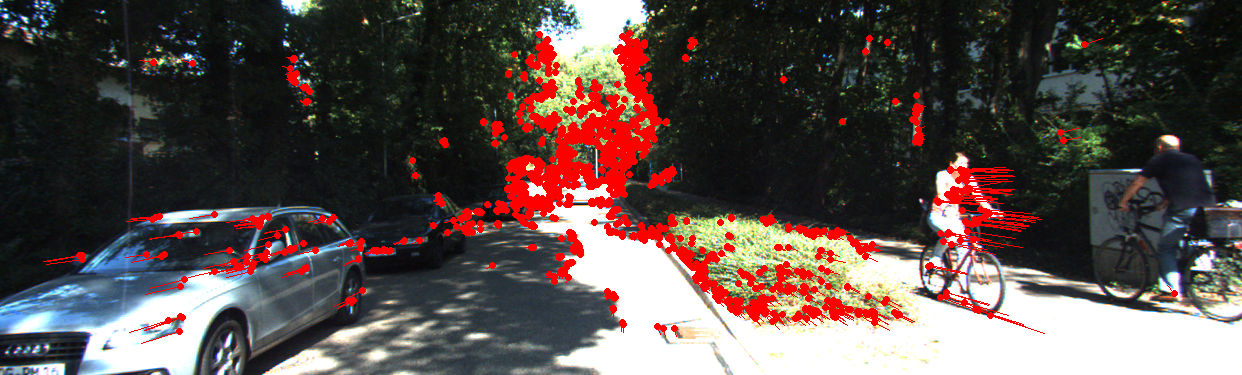

After RANSAC
#matches: 1587


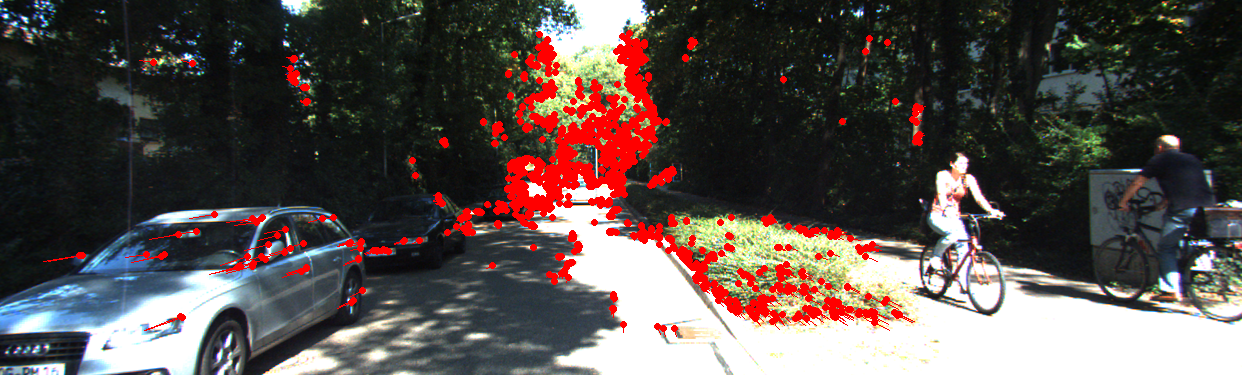

R1: [[-0.99752239  0.00567585  0.07012042]
 [-0.00191736 -0.99856323  0.05355187]
 [ 0.07032362  0.05328474  0.99610006]], |R1| = 0.9999999999999994
R2: [[ 0.999992   -0.00374726  0.00140139]
 [ 0.00374802  0.99999283 -0.00053479]
 [-0.00139938  0.00054004  0.99999888]], |R2| = 0.9999999999999994
t1: [[   0.3637763  -109.08797998    2.88438016]
 [ 110.35531074   -0.3651918    -3.9444187 ]
 [  -2.94410969    3.91840847    0.0014155 ]]
t2: [[  -0.3637763   109.08797998   -2.88438016]
 [-110.35531074    0.3651918     3.9444187 ]
 [   2.94410969   -3.91840847   -0.0014155 ]]


In [40]:
img_tn2 = kitti_imgs[0]
img_tn1 = kitti_imgs[1]
img_t = kitti_imgs[2]

kps_tn1, des_tn1 = extract_features(img_tn1)
kps_t, des_t = extract_features(img_t)
print(f"#kps_tn1: {len(kps_tn1)} #kps_t: {len(kps_t)}")

print("Before RANSAC")
matches = match_features2(des_tn1, des_t)
kps_tn1 = kps_tn1[matches[:,0]]
kps_t = kps_t[matches[:,1]]
print(f"#matches: {len(matches)}")
disp(img_tn1, kps_tn1, kps_t)

# From image coordinate to Normalized image coordinate
kps_tn1_ = kps_tn1 @ np.linalg.inv(kitti_cam_calib).T
kps_t_ = kps_t @ np.linalg.inv(kitti_cam_calib).T

F, inliers = ransac(
  (kps_tn1[matches[:,0]], kps_t[matches[:,1]]),
  FundamentalMatrixTransform,
  min_samples=8,
  residual_threshold=1,
  max_trials=100
)

print("After RANSAC")
matches = matches[inliers]
print(f"#matches: {len(matches)}")
disp(img_tn1, kps_tn1[matches[:,0]], kps_t[matches[:,1]])

E = kitti_cam_calib.T @ F.params @ kitti_cam_calib

np.set_printoptions(suppress=True)
EssentiaToRt(E)
# print(R1)
# print(R2)

# t1, t2, t3, t4 = EssentiaTot(E)
# print(t1)
# print(t2)
# print(t3)
# print(t4)

In [ ]:
x = np.array([1,1,1])
R.T @ x